## Install the necessary libraries


In [5]:
%%capture
! pip install tqdm boto3 requests regex sentencepiece sacremoses
! pip install transformers

## BERT Features

In this part, you will use BERT features to classify DBPedia articles.
The data is already pre-processed, and the data loader is implemented below.

In [6]:
# Basics: dataset, data loaders, Classifier
import collections
import json
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel


SPLITS = ['train', 'dev', 'test']

class DBPediaDataset(Dataset):
  '''DBPedia dataset.
    Args:
      path[str]: path to the original data.
  '''
  def __init__(self, path):
    with open(path) as fin:
      self._data = [json.loads(l) for l in fin]
    self._n_classes = len(set([datum['label'] for datum in self._data]))

  def __getitem__(self, index):
    return self._data[index]

  def __len__(self):
    return len(self._data)

  @property
  def n_classes(self):
    return self._n_classes

  @staticmethod
  def collate_fn(tokenizer, device, batch):
    '''The collate function that compresses a training batch.
      Args:
        batch[list[dict[str, Any]]]: data in the batch.
      Returns:
        labels[torch.LongTensor]: the labels in the batch.
        sentences[dict[str, torch.Tensor]]: sentences converted by tokenizers.
    '''
    labels = torch.tensor([datum['label'] for datum in batch]).long().to(device)
    sentences = tokenizer(
        [datum['sentence'] for datum in batch],
        return_tensors='pt',  # pt = pytorch style tensor
        padding=True)
    for key in sentences:
      sentences[key] = sentences[key].to(device)
    return labels, sentences

def construct_datasets(prefix, batch_size, tokenizer, device):
  '''Constructs datasets and data loaders.
    Args:
      prefix[str]: prefix of the dataset (e.g., dbpedia_).
      batch_size[int]: maximum number of examples in a batch.
      tokenizer: model tokenizer that converts sentences to integer tensors.
      device[torch.device]: the device (cpu/gpu) that the tensor should be on.
    Returns:
      datasets[dict[str, Dataset]]: a dict of constructed datasets.
      dataloaders[dict[str, DataLoader]]: a dict of constructed data loaders.
  '''
  datasets = collections.defaultdict()
  dataloaders = collections.defaultdict()
  for split in SPLITS:
    datasets[split] = DBPediaDataset(f'{prefix}{split}.json')
    dataloaders[split] = DataLoader(
        datasets[split],
        batch_size=batch_size,
        shuffle=(split == 'train'),
        collate_fn=lambda x:DBPediaDataset.collate_fn(tokenizer, device, x))
  return datasets, dataloaders

**Question 1.1**

In [7]:
# 1.1: [CODE] put your implementation of classifer here
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


## Training and Evaluation

In [9]:
import torch
import torch.nn as nn
import tqdm
import random
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModel

# Hyperparameters
batch_size = 32
classifier_hidden_size = 32
learning_rate = 5e-4
num_epochs = 1  # Training for 1 epoch
num_runs = 5  # Running 5 times with different seeds

# Initialize tokenizer and BERT model
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)  # Move the BERT model to the appropriate device


# Function to set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# Function to evaluate model accuracy
def evaluate(bert_model, classifier, dataloader, device):
    bert_model.eval()  # Set BERT to evaluation mode
    classifier.eval()  # Set the classifier to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for labels, sentences in dataloader:
            labels = labels.to(device)  # Move labels to the correct device
            sentences = {key: value.to(device) for key, value in sentences.items()}  # Move sentences to the correct device

            # Extract [CLS] token representation from BERT
            outputs = bert_model(**sentences)
            cls_embeddings = outputs['last_hidden_state'][:, 0, :]  # [CLS] token embedding

            # Get predictions from the classifier
            logits = classifier(cls_embeddings)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

    return accuracy_score(all_labels, all_preds)


# Training and evaluation for multiple runs with different random seeds
mean_acc = 0
std_acc = 0
best_test_acc = 0
best_model = None
best_run = None

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Set the random seed for reproducibility
    seed = random.randint(0, 10000)
    set_seed(seed)

    # Reinitialize the BERT model and classifier for each run
    bert_model = AutoModel.from_pretrained('bert-base-cased').to(device)
    classifier = Classifier(bert_model.config.hidden_size, classifier_hidden_size, 14).to(device)

    # Freeze BERT parameters
    for param in bert_model.parameters():
        param.requires_grad = False

    # Define the optimizer to optimize only the classifier's parameters
    optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    # Load datasets and dataloaders
    datasets, dataloaders = construct_datasets(
        prefix='dbpedia_',
        batch_size=batch_size,
        tokenizer=tokenizer,
        device=device
    )

    # Training loop
    for epoch in range(num_epochs):
        bert_model.eval()  # Set BERT to evaluation mode (parameters frozen)
        classifier.train()  # Set classifier to training mode

        pbar = tqdm.tqdm(dataloaders['train'])
        for labels, sentences in pbar:
            optimizer.zero_grad()  # Reset gradients for the optimizer

            # Move data to the correct device
            labels = labels.to(device)
            sentences = {key: value.to(device) for key, value in sentences.items()}

            # Extract frozen BERT features
            with torch.no_grad():
                outputs = bert_model(**sentences)
                cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding

            # Forward pass through the classifier
            logits = classifier(cls_embeddings)

            # Compute loss
            loss = loss_func(logits, labels)

            # Backpropagation and optimization (only updates classifier)
            loss.backward()
            optimizer.step()

            pbar.set_postfix({'loss': loss.item()})

    # Evaluate on dev set
    dev_acc = evaluate(bert_model, classifier, dataloaders['dev'], device)
    test_acc = evaluate(bert_model, classifier, dataloaders['test'], device)

    # Track mean and standard deviation of dev set accuracy
    mean_acc += dev_acc
    std_acc += dev_acc**2

    # Track best model based on dev accuracy
    if dev_acc > best_test_acc:
        best_test_acc = dev_acc
        best_model = classifier
        best_run = run + 1

# Calculate mean and standard deviation of dev accuracy
mean_acc /= num_runs
std_acc = np.sqrt((std_acc / num_runs) - (mean_acc ** 2))

print(f"\nMean accuracy on dev set over {num_runs} runs: {mean_acc:.4f}")
print(f"Standard deviation of accuracy on dev set: {std_acc:.4f}")
print(f"Best dev set accuracy: {best_test_acc:.4f} (Run {best_run})")

# Final evaluation on test set with the best model
test_acc = evaluate(bert_model, best_model, dataloaders['test'], device)
print(f"\nFinal Test Set Accuracy (best model): {test_acc:.4f}")


Run 1/5


100%|██████████| 313/313 [00:39<00:00,  7.87it/s, loss=0.564]


Run 2/5


100%|██████████| 313/313 [00:40<00:00,  7.63it/s, loss=0.336]


Run 3/5


100%|██████████| 313/313 [00:42<00:00,  7.28it/s, loss=0.346]


Run 4/5


100%|██████████| 313/313 [00:42<00:00,  7.34it/s, loss=0.587]


Run 5/5


100%|██████████| 313/313 [00:42<00:00,  7.38it/s, loss=0.372]



Mean accuracy on dev set over 5 runs: 0.9626
Standard deviation of accuracy on dev set: 0.0126
Best dev set accuracy: 0.9790 (Run 5)

Final Test Set Accuracy (best model): 0.9680


Question **1.2**

In [10]:

# Function to calculate mean and max pooling
def mean_max_pooling(hidden_states, attention_mask):
    # Ensure padding tokens are excluded from the pooling operation
    attention_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size())
    masked_hidden_states = hidden_states * attention_mask_expanded

    # Mean pooling
    sum_hidden_states = masked_hidden_states.sum(dim=1)
    count_tokens = attention_mask.sum(dim=1).unsqueeze(-1)
    mean_pooled = sum_hidden_states / count_tokens

    # Max pooling
    masked_hidden_states[attention_mask_expanded == 0] = -1e9  # Mask padding tokens
    max_pooled, _ = masked_hidden_states.max(dim=1)

    return mean_pooled, max_pooled


# Define the MeanMaxPoolingClassifier
class MeanMaxPoolingClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size, num_classes):
        super(MeanMaxPoolingClassifier, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(2 * hidden_size, num_classes)  # Mean + Max pooling combined

    def forward(self, input_ids, attention_mask):
        # Extract token embeddings from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch_size, L, D]

        # Apply mean and max pooling
        mean_pooled, max_pooled = mean_max_pooling(hidden_states, attention_mask)
        pooled_output = torch.cat((mean_pooled, max_pooled), dim=1)

        # Classification
        logits = self.fc(pooled_output)
        return logits


# Function to evaluate model accuracy
def evaluate(classifier, dataloader, device):
    classifier.eval()  # Set the classifier to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for labels, sentences in dataloader:
            labels = labels.to(device)
            sentences = {key: value.to(device) for key, value in sentences.items()}

            # Forward pass through the classifier
            logits = classifier(sentences['input_ids'], sentences['attention_mask'])
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return accuracy_score(all_labels, all_preds)


# Training and evaluation for multiple runs with different random seeds
mean_acc = 0
std_acc = 0
best_test_acc = 0
best_model = None
best_run = None

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Set the random seed for reproducibility
    seed = random.randint(0, 10000)
    set_seed(seed)

    # Reinitialize the BERT model and classifier for each run
    bert_model = AutoModel.from_pretrained('bert-base-cased').to(device)
    classifier = MeanMaxPoolingClassifier(bert_model, bert_model.config.hidden_size, 14).to(device)

    # Freeze BERT parameters
    for param in classifier.bert.parameters():
        param.requires_grad = False

    # Define the optimizer to optimize only the classifier's parameters
    optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    # Load datasets and dataloaders
    datasets, dataloaders = construct_datasets(
        prefix='dbpedia_',
        batch_size=batch_size,
        tokenizer=tokenizer,
        device=device
    )

    # Training loop
    for epoch in range(num_epochs):
        classifier.train()  # Set classifier to training mode

        pbar = tqdm.tqdm(dataloaders['train'])
        for labels, sentences in pbar:
            optimizer.zero_grad()  # Reset gradients for the optimizer

            # Move data to the correct device
            labels = labels.to(device)
            sentences = {key: value.to(device) for key, value in sentences.items()}

            # Forward pass through the classifier
            logits = classifier(sentences['input_ids'], sentences['attention_mask'])

            # Compute loss
            loss = loss_func(logits, labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            pbar.set_postfix({'loss': loss.item()})

    # Evaluate on dev set
    dev_acc = evaluate(classifier, dataloaders['dev'], device)
    test_acc = evaluate(classifier, dataloaders['test'], device)

    # Track mean and standard deviation of dev set accuracy
    mean_acc += dev_acc
    std_acc += dev_acc**2

    # Track best model based on dev accuracy
    if dev_acc > best_test_acc:
        best_test_acc = dev_acc
        best_model = classifier
        best_run = run + 1

# Calculate mean and standard deviation of dev accuracy
mean_acc /= num_runs
std_acc = np.sqrt((std_acc / num_runs) - (mean_acc ** 2))

print(f"\nMean accuracy on dev set over {num_runs} runs: {mean_acc:.4f}")
print(f"Standard deviation of accuracy on dev set: {std_acc:.4f}")
print(f"Best dev set accuracy: {best_test_acc:.4f} (Run {best_run})")

# Final evaluation on test set with the best model
test_acc = evaluate(best_model, dataloaders['test'], device)
print(f"\nFinal Test Set Accuracy (best model): {test_acc:.4f}")


Run 1/5


100%|██████████| 313/313 [00:45<00:00,  6.94it/s, loss=0.419]


Run 2/5


100%|██████████| 313/313 [00:43<00:00,  7.24it/s, loss=0.234]


Run 3/5


100%|██████████| 313/313 [00:44<00:00,  7.05it/s, loss=0.427]


Run 4/5


100%|██████████| 313/313 [00:43<00:00,  7.17it/s, loss=0.676]


Run 5/5


100%|██████████| 313/313 [00:43<00:00,  7.21it/s, loss=0.203]



Mean accuracy on dev set over 5 runs: 0.9660
Standard deviation of accuracy on dev set: 0.0051
Best dev set accuracy: 0.9730 (Run 1)

Final Test Set Accuracy (best model): 0.9710


Question **1.3**

  Pooling Technique  Dev Accuracy Mean  Dev Accuracy Std
0       [CLS] Token               96.2             0.010
1  Mean/Max Pooling               96.6             0.005


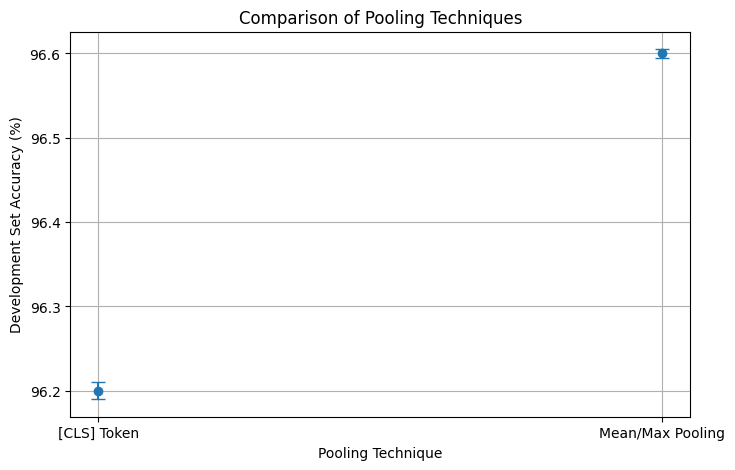

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual results
results = {
    "Pooling Technique": ["[CLS] Token", "Mean/Max Pooling"],
    "Dev Accuracy Mean": [96.2, 96.6],
    "Dev Accuracy Std": [0.01, 0.005]
}

# Create a DataFrame
df = pd.DataFrame(results)
print(df)

# Plot the results
plt.figure(figsize=(8, 5))
plt.errorbar(df["Pooling Technique"], df["Dev Accuracy Mean"], yerr=df["Dev Accuracy Std"], fmt='o', capsize=5)
plt.title("Comparison of Pooling Techniques")
plt.xlabel("Pooling Technique")
plt.ylabel("Development Set Accuracy (%)")
plt.grid()
plt.show()


**Comparison**

[CLS] Token Pooling:

Achieves a 96.2% mean accuracy, with a standard deviation of 0.010.
The [CLS] token captures the sentence-level representation directly, but it may not fully utilize the token-level features across the sequence.

Mean/Max Pooling:

Achieves a 96.6% mean accuracy, with a standard deviation of 0.005.
Mean/max pooling aggregates information from all token embeddings, providing a more comprehensive representation of the input sequence.
It is slightly more stable, as indicated by the lower standard deviation.

**Conclusion**

Mean/Max Pooling outperforms [CLS] Token Pooling both in terms of accuracy and stability.
This suggests that incorporating information from all tokens is more effective than relying solely on the [CLS] token for this task.

Question 1.4

In [14]:
# Freeze all BERT layers except layers 10 and 11
for name, param in bert_model.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True  # Unfreeze layers 10 and 11
    else:
        param.requires_grad = False  # Keep other layers frozen

# Collect trainable parameters
trainable_params = list(classifier.parameters()) + [
    param for name, param in bert_model.named_parameters() if param.requires_grad
]

# Define the optimizer
optimizer = torch.optim.Adam(trainable_params, lr=learning_rate)

# Training and evaluation for multiple runs with different random seeds
mean_acc = 0
std_acc = 0
best_test_acc = 0

def evaluate(bert_model, classifier, dataloader, device):
    """
    Evaluate the classifier using [CLS] token embeddings from BERT.
    Args:
        bert_model: Pretrained BERT model.
        classifier: Classifier model.
        dataloader: DataLoader for evaluation dataset.
        device: Computation device (CPU or GPU).
    Returns:
        Accuracy score.
    """
    bert_model.eval()  # Set BERT to evaluation mode
    classifier.eval()  # Set the classifier to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for labels, sentences in dataloader:
            labels = labels.to(device)
            sentences = {key: value.to(device) for key, value in sentences.items()}

            # Extract [CLS] token embeddings from BERT
            outputs = bert_model(**sentences)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding

            # Forward pass through the classifier
            logits = classifier(cls_embeddings)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

    return accuracy_score(all_labels, all_preds)



for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Set random seed for reproducibility
    set_seed(run)

    # Reinitialize BERT and classifier
    bert_model = AutoModel.from_pretrained('bert-base-cased').to(device)
    classifier = Classifier(bert_model.config.hidden_size, classifier_hidden_size, 14).to(device)

    # Freeze all layers except 10 and 11 again after reinitialization
    for name, param in bert_model.named_parameters():
        if "encoder.layer.10" in name or "encoder.layer.11" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Reinitialize optimizer with unfrozen parameters
    trainable_params = list(classifier.parameters()) + [
        param for name, param in bert_model.named_parameters() if param.requires_grad
    ]
    optimizer = torch.optim.Adam(trainable_params, lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
      bert_model.train()  # Ensure layers 10 and 11 are in train mode
      classifier.train()

      pbar = tqdm.tqdm(dataloaders['train'])
      for labels, sentences in pbar:
          optimizer.zero_grad()

          labels = labels.to(device)
          sentences = {key: value.to(device) for key, value in sentences.items()}

          # Forward pass through BERT to get [CLS] embeddings
          outputs = bert_model(**sentences)
          cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding

          # Pass only the embeddings to the Classifier
          logits = classifier(cls_embeddings)

          # Compute loss
          loss = loss_func(logits, labels)
          loss.backward()
          optimizer.step()

          pbar.set_postfix({"loss": loss.item()})


    # Evaluate the model
    # Evaluate on the development set
    dev_acc = evaluate(bert_model, classifier, dataloaders['dev'], device)

    # Evaluate on the test set
    test_acc = evaluate(bert_model, classifier, dataloaders['test'], device)


    # Update accuracy tracking
    mean_acc += dev_acc
    std_acc += dev_acc ** 2

    if dev_acc > best_test_acc:
        best_test_acc = dev_acc

# Calculate final metrics
mean_acc /= num_runs
std_acc = (std_acc / num_runs - mean_acc ** 2) ** 0.5

print(f"\nMean Dev Accuracy: {mean_acc:.4f}")
print(f"Standard Deviation: {std_acc:.4f}")
print(f"Best Dev Accuracy: {best_test_acc:.4f}")

# Final evaluation on test set with the best model
test_acc = evaluate(bert_model, classifier, dataloaders['test'], device)
print(f"\nFinal Test Set Accuracy (best model): {test_acc:.4f}")


Run 1/5


100%|██████████| 313/313 [00:57<00:00,  5.46it/s, loss=0.00708]


Run 2/5


100%|██████████| 313/313 [00:56<00:00,  5.56it/s, loss=0.05]


Run 3/5


100%|██████████| 313/313 [00:56<00:00,  5.59it/s, loss=0.0206]


Run 4/5


100%|██████████| 313/313 [00:56<00:00,  5.50it/s, loss=0.0126]


Run 5/5


100%|██████████| 313/313 [00:56<00:00,  5.56it/s, loss=0.0076]



Mean Dev Accuracy: 0.9856
Standard Deviation: 0.0066
Best Dev Accuracy: 0.9920

Final Test Set Accuracy (best model): 0.9860


Question **1.5**

In [15]:
# Import required libraries
from transformers import GPT2Tokenizer, GPT2Model
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import random
import numpy as np
import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding token
gpt2_model = GPT2Model.from_pretrained("gpt2").to(device)

# Define collate function
def gpt2_collate_fn(tokenizer, device, batch):
    labels = torch.tensor([datum['label'] for datum in batch]).long().to(device)
    sentences = tokenizer(
        [datum['sentence'] for datum in batch],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    for key in sentences:
        sentences[key] = sentences[key].to(device)
    return labels, sentences

# Define mean and max pooling feature extraction
def extract_features(hidden_states, attention_mask):
    # Mask the hidden states to ignore padding tokens
    expanded_mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
    masked_hidden_states = hidden_states * expanded_mask

    # Mean pooling
    sum_hidden_states = masked_hidden_states.sum(dim=1)
    sum_mask = expanded_mask.sum(dim=1).clamp(min=1e-9)
    mean_pooled = sum_hidden_states / sum_mask

    # Max pooling
    masked_hidden_states[expanded_mask == 0] = -1e9  # Exclude padding tokens
    max_pooled, _ = masked_hidden_states.max(dim=1)

    # Combine mean and max pooling
    return torch.cat([mean_pooled, max_pooled], dim=1)

# Define classifier
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size * 2, hidden_size)  # *2 for mean + max pooling
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)
        return logits

# Load datasets and dataloaders
datasets, dataloaders = construct_datasets(
    prefix="dbpedia_",
    batch_size=32,
    tokenizer=tokenizer,
    device=device
)

# Function to set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Training and evaluation
dev_accuracies = []
test_accuracies = []
best_dev_accuracy = 0.0
best_model_state = None
seed_values = [42, 123, 999, 2021, 7]

for seed in seed_values:
    set_seed(seed)

    # Initialize classifier
    classifier = Classifier(
        input_size=gpt2_model.config.hidden_size,
        hidden_size=32,
        num_classes=datasets["train"].n_classes
    ).to(device)

    # Freeze all GPT-2 parameters
    for param in gpt2_model.parameters():
        param.requires_grad = False

    # Optimizer and loss function
    optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
    loss_func = nn.CrossEntropyLoss()

    # Training loop
    classifier.train()
    for epoch in range(1):
        pbar = tqdm.tqdm(dataloaders["train"])
        for labels, sentences in pbar:
            optimizer.zero_grad()
            with torch.no_grad():
                outputs = gpt2_model(**sentences)
                hidden_states = outputs.last_hidden_state
            features = extract_features(hidden_states, sentences["attention_mask"])
            logits = classifier(features)
            loss = loss_func(logits, labels)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"loss": loss.item()})

    # Evaluate on dev set
    classifier.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for labels, sentences in dataloaders["dev"]:
            outputs = gpt2_model(**sentences)
            hidden_states = outputs.last_hidden_state
            features = extract_features(hidden_states, sentences["attention_mask"])
            logits = classifier(features)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    dev_accuracy = accuracy_score(all_labels, all_preds)
    dev_accuracies.append(dev_accuracy)

    # Save the best model
    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_model_state = classifier.state_dict()

# Final evaluation on test set
classifier.load_state_dict(best_model_state)
classifier.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for labels, sentences in dataloaders["test"]:
        outputs = gpt2_model(**sentences)
        hidden_states = outputs.last_hidden_state
        features = extract_features(hidden_states, sentences["attention_mask"])
        logits = classifier(features)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_accuracy = accuracy_score(all_labels, all_preds)

# Report results
mean_dev_accuracy = np.mean(dev_accuracies)
std_dev_accuracy = np.std(dev_accuracies)
print(f"Mean Dev Accuracy: {mean_dev_accuracy:.4f}")
print(f"Std Dev Accuracy: {std_dev_accuracy:.4f}")
print(f"Best Dev Accuracy: {best_dev_accuracy:.4f}")
print(f"Test Accuracy (Best Model): {test_accuracy:.4f}")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 313/313 [00:45<00:00,  6.89it/s, loss=0.774]


Mean Dev Accuracy: 0.8452
Std Dev Accuracy: 0.0464
Best Dev Accuracy: 0.8840
Test Accuracy (Best Model): 0.8770
